<a href="https://colab.research.google.com/github/cyan9212/House_Price_Prediction/blob/main/houseprice_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# **1. 데이터 불러오기**

In [4]:
#데이터 불러오기
from google.colab import files

uploaded = files.upload()
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **2. EDA & FE**

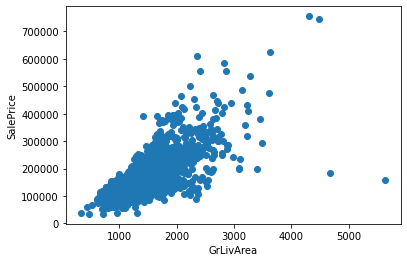

In [5]:
#Data Processing
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.xlabel('GrLivArea'); plt.ylabel('SalePrice')
plt.show()

In [6]:
#이상치 제거
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

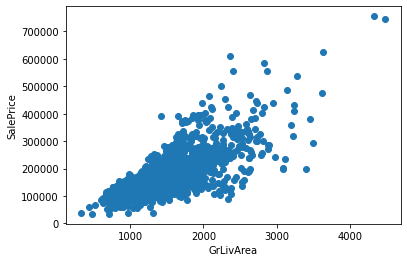

In [7]:
#이상치 제거를 산점도로 확인
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.xlabel('GrLivArea'); plt.ylabel('SalePrice')
plt.show()

In [8]:
#상관관계가 0.3 이상인 피처들을 추출
cor = train_data.corr()
cor_fe = cor.index[abs(cor['SalePrice']) >= 0.3]
cor_fe

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

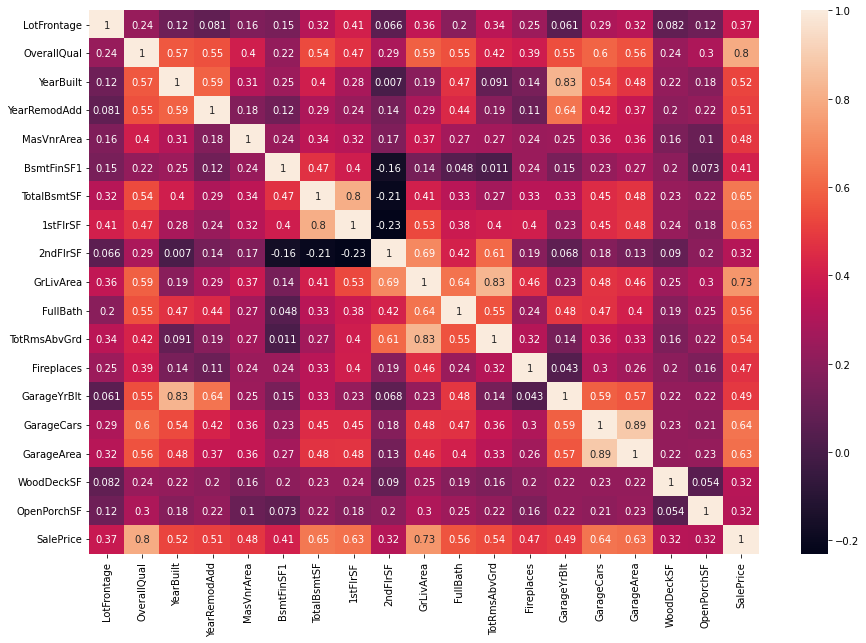

In [9]:
#상관관계가 0.3 이상인 변수들만 히트맵으로 출력
plt.figure(figsize=(15,10))
sns.heatmap(train_data[cor_fe].corr(), annot=True)

In [10]:
fe_name = list(test_data)
df_train = train_data[fe_name]
df = pd.concat((df_train, test_data))
print(train_data.shape, test_data.shape, df.shape)

(1458, 81) (1459, 80) (2917, 80)


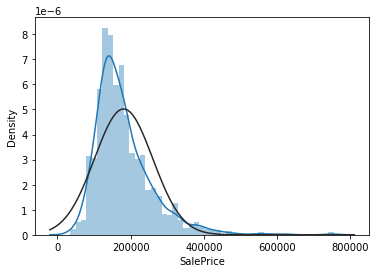

In [11]:
#타겟변수 확인
from scipy import stats
from scipy.stats import norm

sns.distplot(train_data['SalePrice'],fit = norm) #fit을 정규분포로 설정

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.25959976626, 180932.91906721535, 0.9320154492892366))

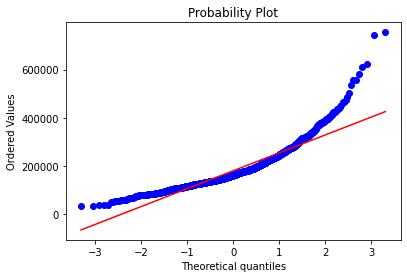

In [12]:
# QQ플롯 확인
stats.probplot(train_data['SalePrice'], plot=plt)

타겟 변수인 SalePrice의 왜도를 확인한 결과 왼쪽으로 치우쳐 있고 정규성을 띄지 않고 있는것을 확인

정규분포를 따르게 하기 위해 로그변환을 

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3985294832980733, 12.024015155682548, 0.9953918721417083))

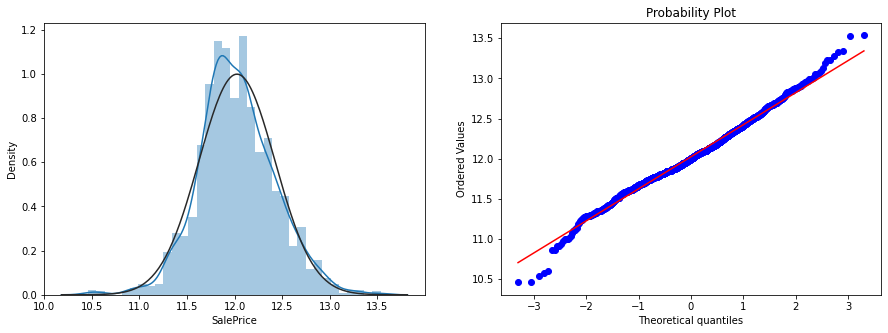

In [13]:
#로그변환
train_data['SalePrice'] = np.log1p(train_data['SalePrice']) #log1p() 대신 log()를 사용하면 x값이 0일때 무한대가 되므로 log1p()를 사용
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_data['SalePrice'], fit=norm, ax = ax[0])
stats.probplot(train_data['SalePrice'],plot=ax[1])

Box Cox 변환 후 타겟 데이터가 정규분포를 따르는것을 확인할 수 있다.

In [14]:
target_data = train_data['SalePrice']

In [15]:
null_df = df.isna().sum()/df.shape[0]*100
null_df = null_df.drop(null_df[null_df == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': null_df})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


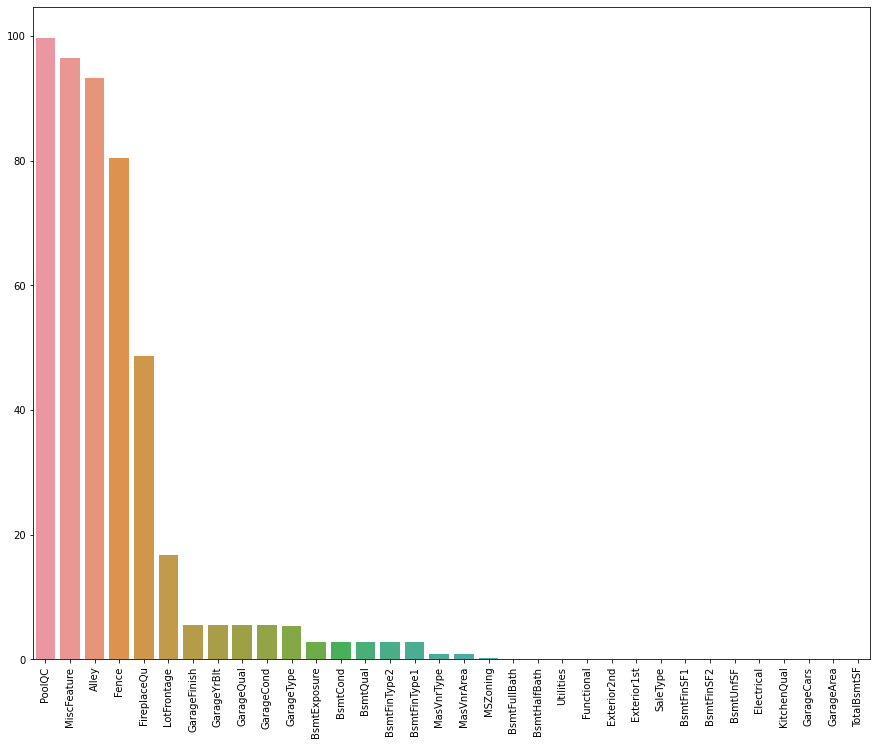

In [16]:
# 결측값으 비율을 xticks 그래프로 시각화
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=null_df.index, y=null_df)

**PoolQC** : 데이터의 NA는 풀이 없음을 의미한다. 결측치의 비율이 99%로 매우 높고 대부분의 주택에는 수영장이 없음을 감안할 때 의미있는 변수로 판단

In [17]:
df['PoolQC'] = df['PoolQC'].fillna('None')

**MiscFeature** : data description에 의하면 NA는 "no misc feature"로 기타기능 없음을 의미한다.

In [18]:
df['MiscFeature'] = df['MiscFeature'].fillna('None')

**Alley** : data description에 의하면 NA는 "no alley access"로 골목 접근 금지를 의미합니다.

In [19]:
df['Alley'] = df['Alley'].fillna('None')

**Fence** : data description에 의하면NA는 "no fence"로 울타리가 없는 것을 의미합니다.

In [20]:
df['Fence'] = df['Fence'].fillna('None')

**FireplaceQu** : data description에 의하면NA는 "no fireplace"로 난로가 없는 것을 의미합니다

In [21]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

**LotFrontage** : 주택건물에 연결된 각 거리의 면적이 주변의 다른 주택과 비슷한 지역일 가능성이 높기 때문에 이웃의 LotFrontage의 중앙값으로 결측치를 채웁니다

In [22]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**GarageType, GarageFinish, GarageQual** and **GarageCond** : 누락된 데이터를 None값으로 대체합니다

In [23]:
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    df[col] = df[col].fillna('Null')

**GarageYrBlt, GarageArea** and **GarageCars** : 결측치를 0으로 대체합니다 (차고가 없는 것은 차고에 차가 없는 것을 의미하기 때문입니다.)

In [24]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath** and **BsmtHalfBath** : 지하실이 없으면 결측값이 0 일 가능성이 높기 때문에 결측치를 0으로 대체합니다

In [25]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1** and **BsmtFinType2** : 이러한 모든 범주 형 지하실 관련 기능에 대해 NaN은 지하실이 없음을 의미합니다.

In [26]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

**MasVnrArea** and **MasVnrType** : NA는 아마도이 집들에 대한 고정 베니어가 없다는 것을 의미합니다. Area은 0을, Type은 없음을 채울 수 있습니다.

In [27]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

**MSZoning** (The general zoning classification) : 'RL'이 가장 일반적인 값입니다. 따라서 'RL'로 결 측값을 채울 수 있습니다

In [28]:
df['MSZoning'] = df['MSZoning'].fillna('RL')

**Utilities** : 이 범주 기능의 경우 하나의 "NoSeWa"및 2 NA를 제외한 모든 데이터는 "AllPub"입니다. 'NoSewa'가있는 집이 훈련 세트에 있으므로이 기능은 예측 모델링에 도움이되지 않습니다. 그러므로 변수를 제거해줍니다

In [29]:
df = df.drop(['Utilities'], axis=1)

**Functional** : data description에 의하면 NA는 typical을 의미합니다

In [30]:
df['Functional'] = df['Functional'].fillna('Typ')

**Electrical** : 하나의 NA 값이 있습니다. 이 기능은 대부분 'SBrkr'을 가지므로 결측값으로 설정할 수 있습니다.

In [31]:
df['Electrical'] =  df['Electrical'].fillna(df['Electrical'].mode()[0])

**KitchenQual**: 전기와 동일한 하나의 NA 값만으로 KitchenQual의 결 측값에 'TA'(가장 빈번)를 설정합니다.

In [32]:
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

**Exterior1st** and **Exterior2nd** : 두변수 모두 Exterior 1 & 2 하나의 결측값만 가집니다. 따라서 가장 일반적인 문자로 대체할 것입니다.

In [33]:
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

**SaleType** : 가장 빈번한 데이터인 WD로 결측치를 대체합니다

In [34]:
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

**MSSubClass** : Na는 건물 등급 없음을 의미합니다. 결측값을 None으로 대체 할 수 있습니다

In [35]:
df['MSSubClass'] = df['MSSubClass'].fillna('None')

In [36]:
# 결측치 유무 확인
null_df = df.isnull().sum() / len(df) * 100
null_df = null_df.drop(null_df[null_df == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':null_df})
missing_data

,Missing Ratio


결측치 확인 결과 결측치가 없는것으로 판단되었다.

In [37]:
# 데이터 범주화
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

건물의 클래스인 **MSSubClass**,전반적인 조건 등급인 **OverallCond**,연 월의 변수인 **YrSold**와 **MoSold** 피처에 대해서 int가 아닌 범주형으로 astype 함수를 이용하여 범주화

In [38]:
df_obj = df.select_dtypes(include='object')
df_obj.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,2,2008,WD,Normal
1,20,RL,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,5,2007,WD,Normal
2,60,RL,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,9,2008,WD,Normal
3,70,RL,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,2,2006,WD,Abnorml
4,60,RL,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,12,2008,WD,Normal


In [39]:
li_obj = list(df_obj.columns)

범주형 변수를 분리

In [40]:
df_num = df.select_dtypes(exclude='object')
df_num.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1,65.0,8450,7,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0
1,2,80.0,9600,6,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0
2,3,68.0,11250,7,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0
3,4,60.0,9550,7,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0
4,5,84.0,14260,8,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0


In [41]:
li_num = list(df_num.columns)

수치형 변수를 분리

In [42]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in cols:
    encoder = LabelEncoder()
    encoder.fit(df[col].values)
    df[col] = encoder.transform(df[col])

범주형 변수들을 LabelEncoding

In [43]:
# 전체 평방 피트
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
# 건축년도 + 리모델링년도
df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
# 전체 Finished Squre feet
df['Total_sqr_footage'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
# 전체 화장실 갯수
df['Total_Bathrooms'] = df['FullBath'] + df['BsmtFullBath'] + df['HalfBath']*0.5 + df['BsmtHalfBath']*0.5
# 전체 현관 면적
df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch']  + df['WoodDeckSF']

특성공학을 통해 각 피처들의 합으로 Total 피쳐를 생성

In [44]:
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasFirePlace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

풀장, 2층, 차고, 지하실, 화로 보유 여부를 나타내는 새로운 피처 생성 (값이 1이면 보유 0이면 미보유)

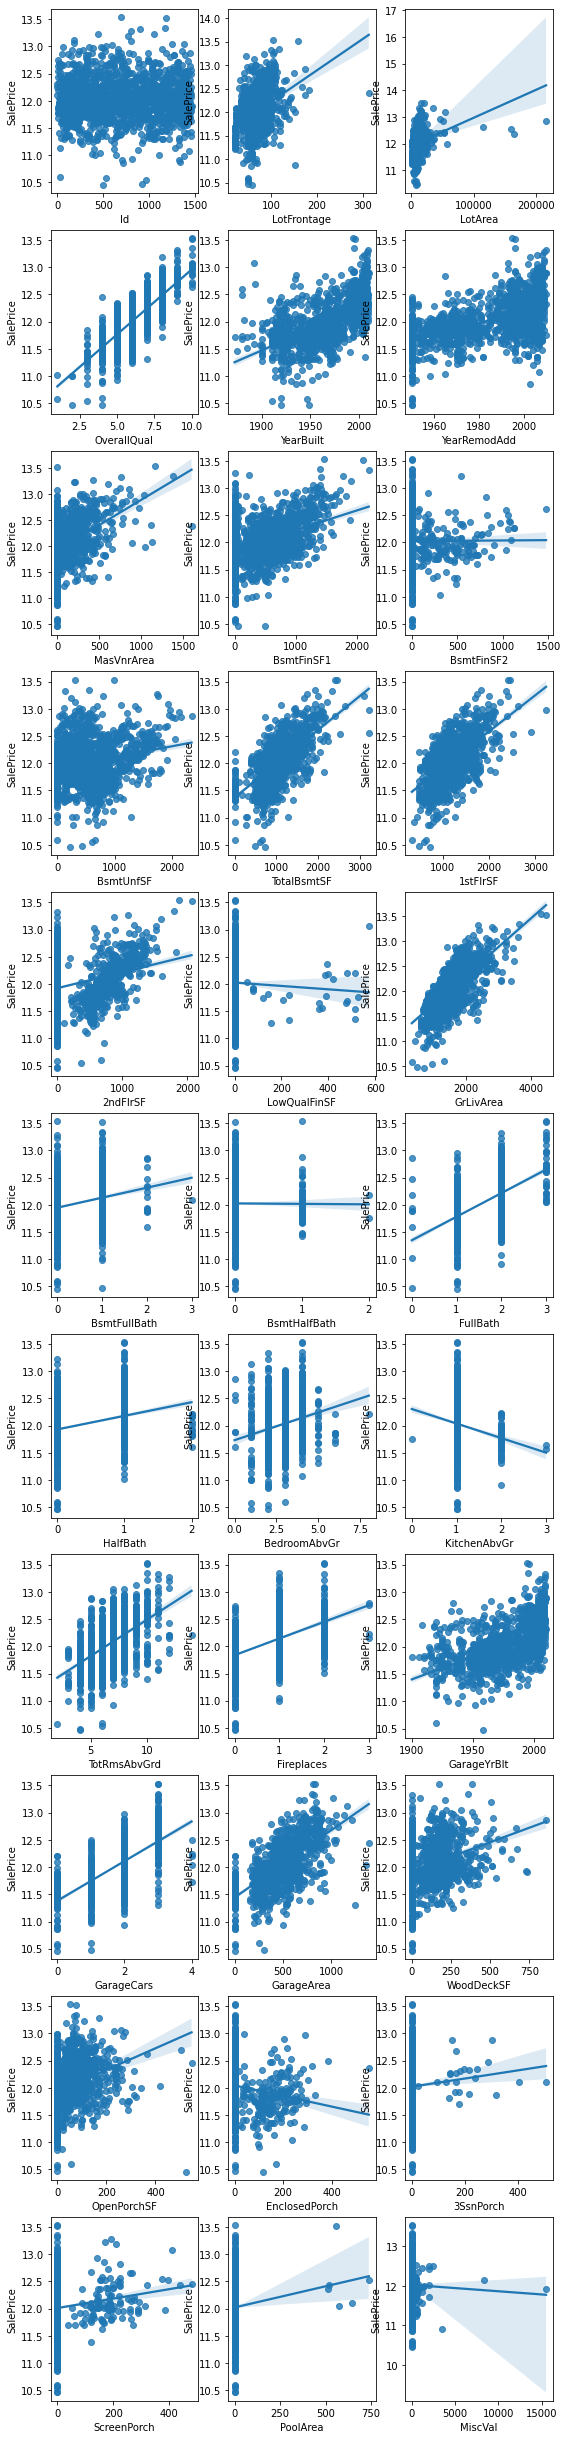

In [45]:
# 33개의 수치형 변수 확인
row = 11
col = 3

fig, ax = plt.subplots(row , col, figsize=(col*3, row*4))

for r in range(row):
    for c in range(col):
        i = r * col + c
        if i< len(li_num):
            sns.regplot(train_data[li_num[i]], target_data, ax = ax[r][c]) #두 연속형 변수의 관계 확인을 위해 regplot으로 시각화

수치형 변수를 그래프로 시각화

In [46]:
stats.pearsonr(train_data[li_num[11]], target_data) #피어슨상관계수 검정 (상관계수, p-value)

(0.6205000189170755, 6.572494159280828e-156)

In [47]:
strong_num = ['OverallQual','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF',
             'FullBath','TotRmsAbvGrd','GarageYrBlt','GarageCars','GrLivArea']

regplot을 그려 선형선이 강한 변수들을 따로 구분
시각적으로 애매한 변수들은 stats.pearsonr() 함수를 사용하여 피어슨상관계수값이 0.5 이상인 변수를 채택

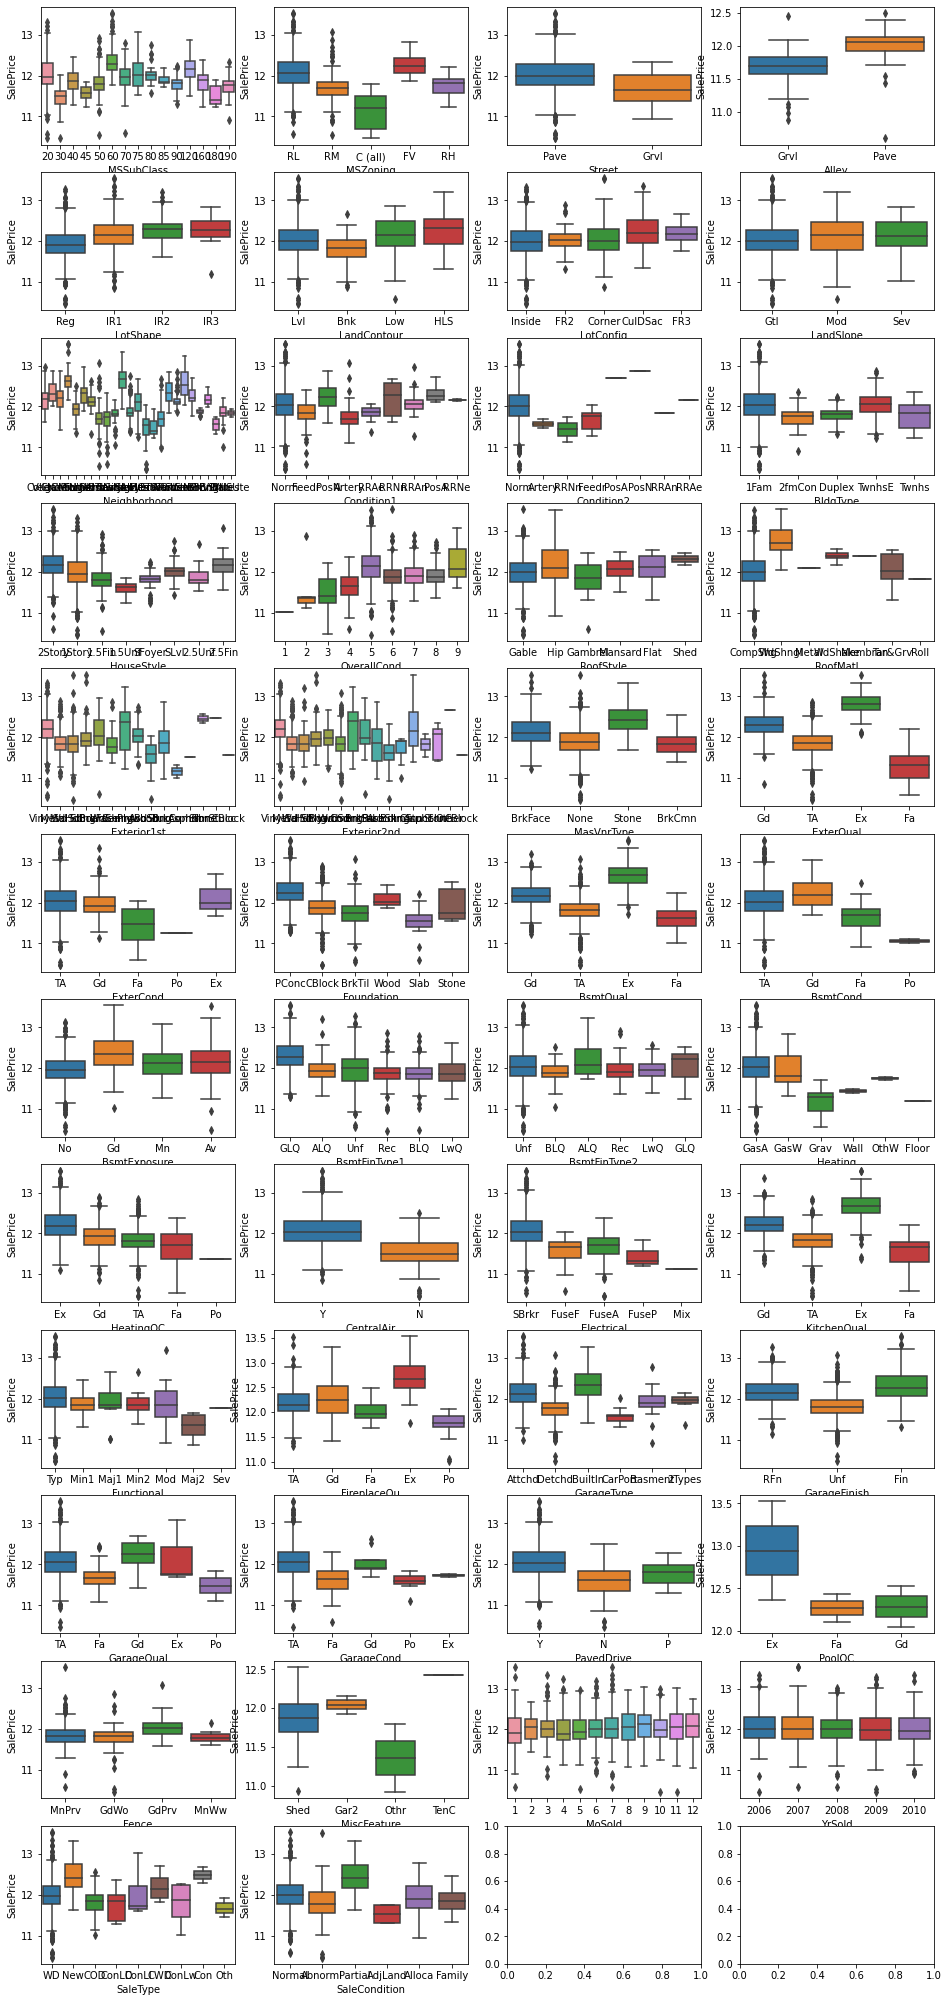

In [48]:
row = 12
col = 4

fig, ax = plt.subplots(row, col, figsize=(col*4, row*3))

for r in range(row):
    for c in range(col):
        i = r*col + c
        if i < len(li_obj):
            sns.boxplot(train_data[li_obj[i]], target_data, ax = ax[r][c])

In [49]:
strong_obj = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

범주형 변수들 경우 boxplot을 고려보아 비교를 하였으며 타겟변수인 SalePrice에 영향을 많이 끼치는 변수들과 약한 변수들을 구분

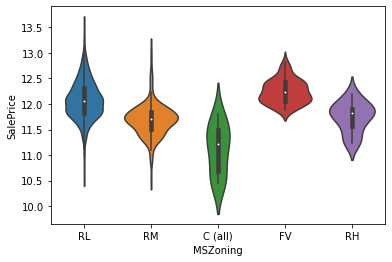

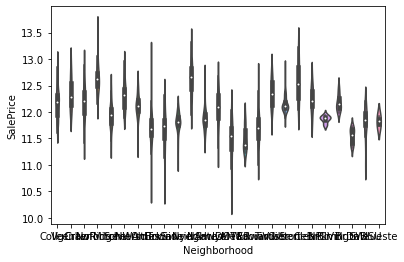

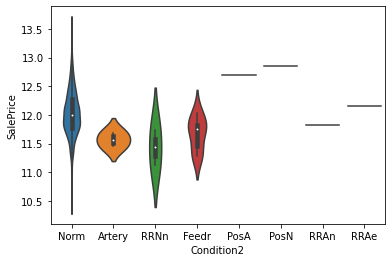

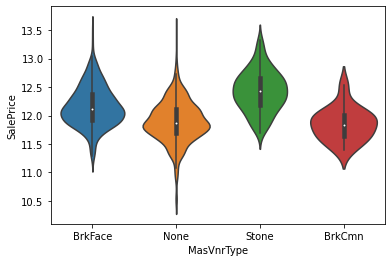

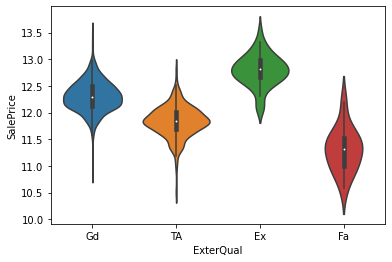

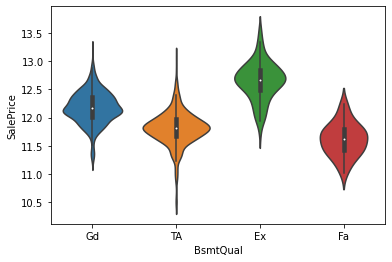

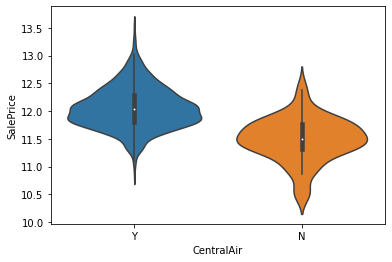

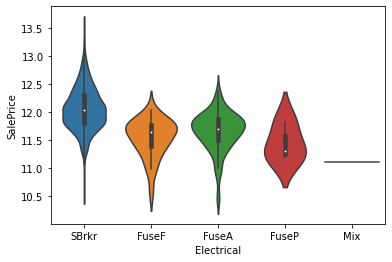

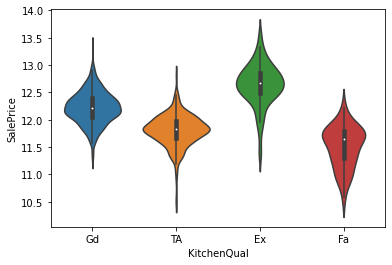

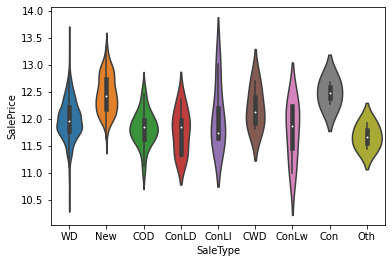

In [50]:
for li in strong_obj:
    sns.violinplot(x = li, y = target_data, data = train_data)
    plt.show()

Boxplot으로 유의하다고 판단되는 변수들을 채택하였고 각 범주들과 SalePrice의 관계를 살펴보기 위해서 violinplot으로 시각화

In [51]:
numeric_features = df.dtypes[df.dtypes != 'object'].index
numeric_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold',
       'YrSold', 'TotalSF', 'YrBltAndRemod', 'Total_sqr_footage',
       'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'has2ndFl

In [52]:
#수치형 변수들의 왜도값 확인
from scipy.stats import skew
skewness = df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skewness = skewness[abs(skewness) > 0.5]
skew_feat = high_skewness.index

print(high_skewness)
print(skew_feat)

MiscVal              21.939672
PoolArea             17.688664
haspool              15.494756
LotArea              13.109495
LowQualFinSF         12.084539
3SsnPorch            11.372080
LandSlope             4.973254
KitchenAbvGr          4.300550
BsmtFinSF2            4.144503
EnclosedPorch         4.002344
ScreenPorch           3.945101
BsmtHalfBath          3.929996
MasVnrArea            2.621719
OpenPorchSF           2.529358
WoodDeckSF            1.844792
Total_porch_sf        1.379521
1stFlrSF              1.257286
Total_sqr_footage     1.253666
LotFrontage           1.103039
GrLivArea             1.068750
TotalSF               1.009157
BsmtFinSF1            0.980645
BsmtUnfSF             0.919688
2ndFlrSF              0.861556
TotRmsAbvGrd          0.749232
Fireplaces            0.725278
HalfBath              0.696666
TotalBsmtSF           0.671751
BsmtFullBath          0.622415
OverallCond           0.569314
YearBuilt            -0.599194
GarageFinish         -0.609953
LotShape

변수들의 왜도를 파악하기 위해서 skew 함수를 사용하고 왜도값이 0.5가 넘는 변수들을 선택

In [53]:
from scipy.special import boxcox1p
lam = 0.15
for feat in skew_feat:
    df[feat] = boxcox1p(df[feat], lam)

In [54]:
# 더미변수 추가
print(df.shape)
df = pd.get_dummies(df)
print(df.shape)

(2917, 89)
(2917, 230)


라벨인코딩을 하지 않는 변수들에 대해서 모델링 처리를 위해 더미변수를 생성

In [55]:
#기존의 train 데이터와 test 데이터로 분리
new_train_data = df[:train_data.shape[0]]
new_test_data = df[train_data.shape[0]:]
new_test_data

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Null,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,5,6.221214,20.479373,0.730463,0.730463,1.540963,0.000000,5,2.055642,14.121376,1961,0.000000,1.540963,1.820334,4,1.820334,1.540963,5,10.105326,1.540963,7.397498,8.780689,11.775114,4,0.730463,11.818680,0.000000,0.0,11.818680,0.000000,0.000000,1,0.000000,2,0.730463,1.540963,2.055642,2.259674,0.000000,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1462,5,6.244956,21.327220,0.730463,0.730463,0.000000,0.000000,6,2.055642,14.116605,1958,6.808145,1.540963,1.820334,4,1.820334,1.540963,0,11.901094,2.259674,0.000000,9.752379,12.943735,4,0.730463,12.943735,0.000000,0.0,12.943735,0.000000,0.000000,1,0.730463,3,0.730463,1.194318,2.259674,2.259674,0.000000,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1463,10,6.073289,21.196905,0.730463,0.730463,0.000000,0.000000,5,1.820334,14.178149,1998,0.000000,1.540963,1.820334,2,1.820334,1.540963,2,11.476685,2.259674,0.000000,7.293500,11.916131,2,0.730463,11.916131,11.151348,0.0,13.551272,0.000000,0.000000,2,0.730463,3,0.730463,1.540963,2.259674,2.259674,0.730463,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,1464,10,6.172972,19.865444,0.730463,0.730463,0.000000,0.000000,6,2.055642,14.179714,1998,3.858807,1.540963,1.820334,4,1.820334,1.540963,2,10.749651,2.259674,0.000000,9.207511,11.910125,0,0.730463,11.910125,11.062536,0.0,13.504453,0.000000,0.000000,2,0.730463,3,0.730463,1.194318,2.440268,2.259674,0.730463,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1465,0,5.093857,17.257255,0.730463,0.730463,0.000000,0.000000,8,1.820334,14.170316,1992,0.000000,1.194318,1.820334,2,1.820334,1.540963,0,8.720170,2.259674,0.000000,12.172900,12.833625,0,0.730463,12.833625,0.000000,0.0,12.833625,0.000000,0.000000,2,0.000000,2,0.730463,1.194318,2.055642,2.259674,0.000000,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,2,3.932510,14.081426,0.730463,0.730463,1.540963,0.000000,4,2.259674,14.135652,1970,0.000000,1.540963,1.820334,4,1.820334,1.540963,6,0.000000,2.259674,0.000000,10.496872,10.496872,2,0.730463,10.496872,10.496872,0.0,12.374860,0.000000,0.000000,1,0.730463,3,0.730463,1.540963,2.055642,2.259674,0.000000,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1455,2916,2,3.932510,14.013314,0.730463,0.730463,1.540963,0.000000,4,1.820334,14.135652,1970,0.000000,1.540963,1.820334,4,1.820334,1.540963,5,8.622254,2.259674,0.000000,8.978567,10.496872,4,0.730463,10.496872,10.496872,0.0,12.374860,0.00

In [56]:
#train 데이터에 target을 concat
new_train_data = pd.concat([new_train_data, target_data], axis=1, sort=False)

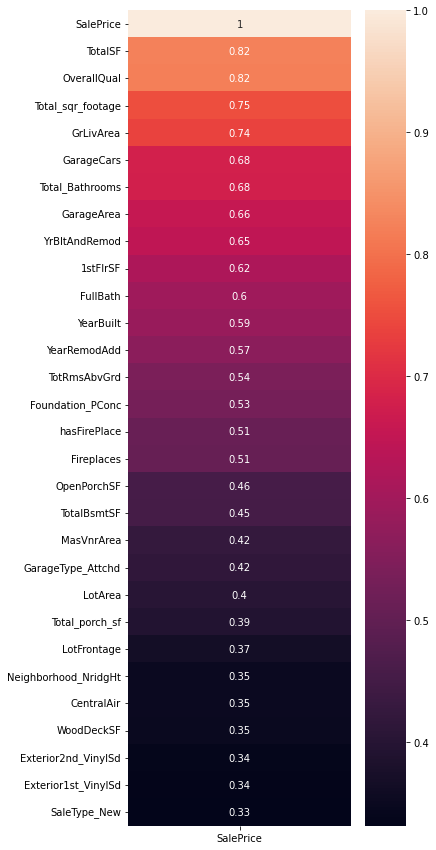

In [57]:
#각 변수와 SalePrice와의 상관계수를 확인
corr_new_train_data = new_train_data.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr_new_train_data[['SalePrice']].sort_values(by=['SalePrice'], ascending=False).head(30), annot=True)

중요한 변수를 확인

In [58]:
col_corr_dict = corr_new_train_data['SalePrice'].sort_values(ascending=False).to_dict()

In [59]:
best_columns = []
for key,value in col_corr_dict.items():
    if (value>=0.33) & (value<0.9) | (value<= -0.325):
        best_columns.append(key)
print('best columns:',len(best_columns))

best columns: 38


상관계수가 0.33 이상이거나 -0.325 이하인 피처들을 선택

In [60]:
#모델링 과정에서 필요없는 변수인 Id와 타겟변수를 제거
new_train_data = new_train_data.drop(['SalePrice'], axis=1)
new_train_data = new_train_data.drop(['Id'], axis=1)
new_test_data = new_test_data.drop(['Id'], axis=1)

In [61]:
final_train_data = new_train_data[best_columns]
final_test_data = new_test_data[best_columns]
final_num = list(final_train_data.columns)

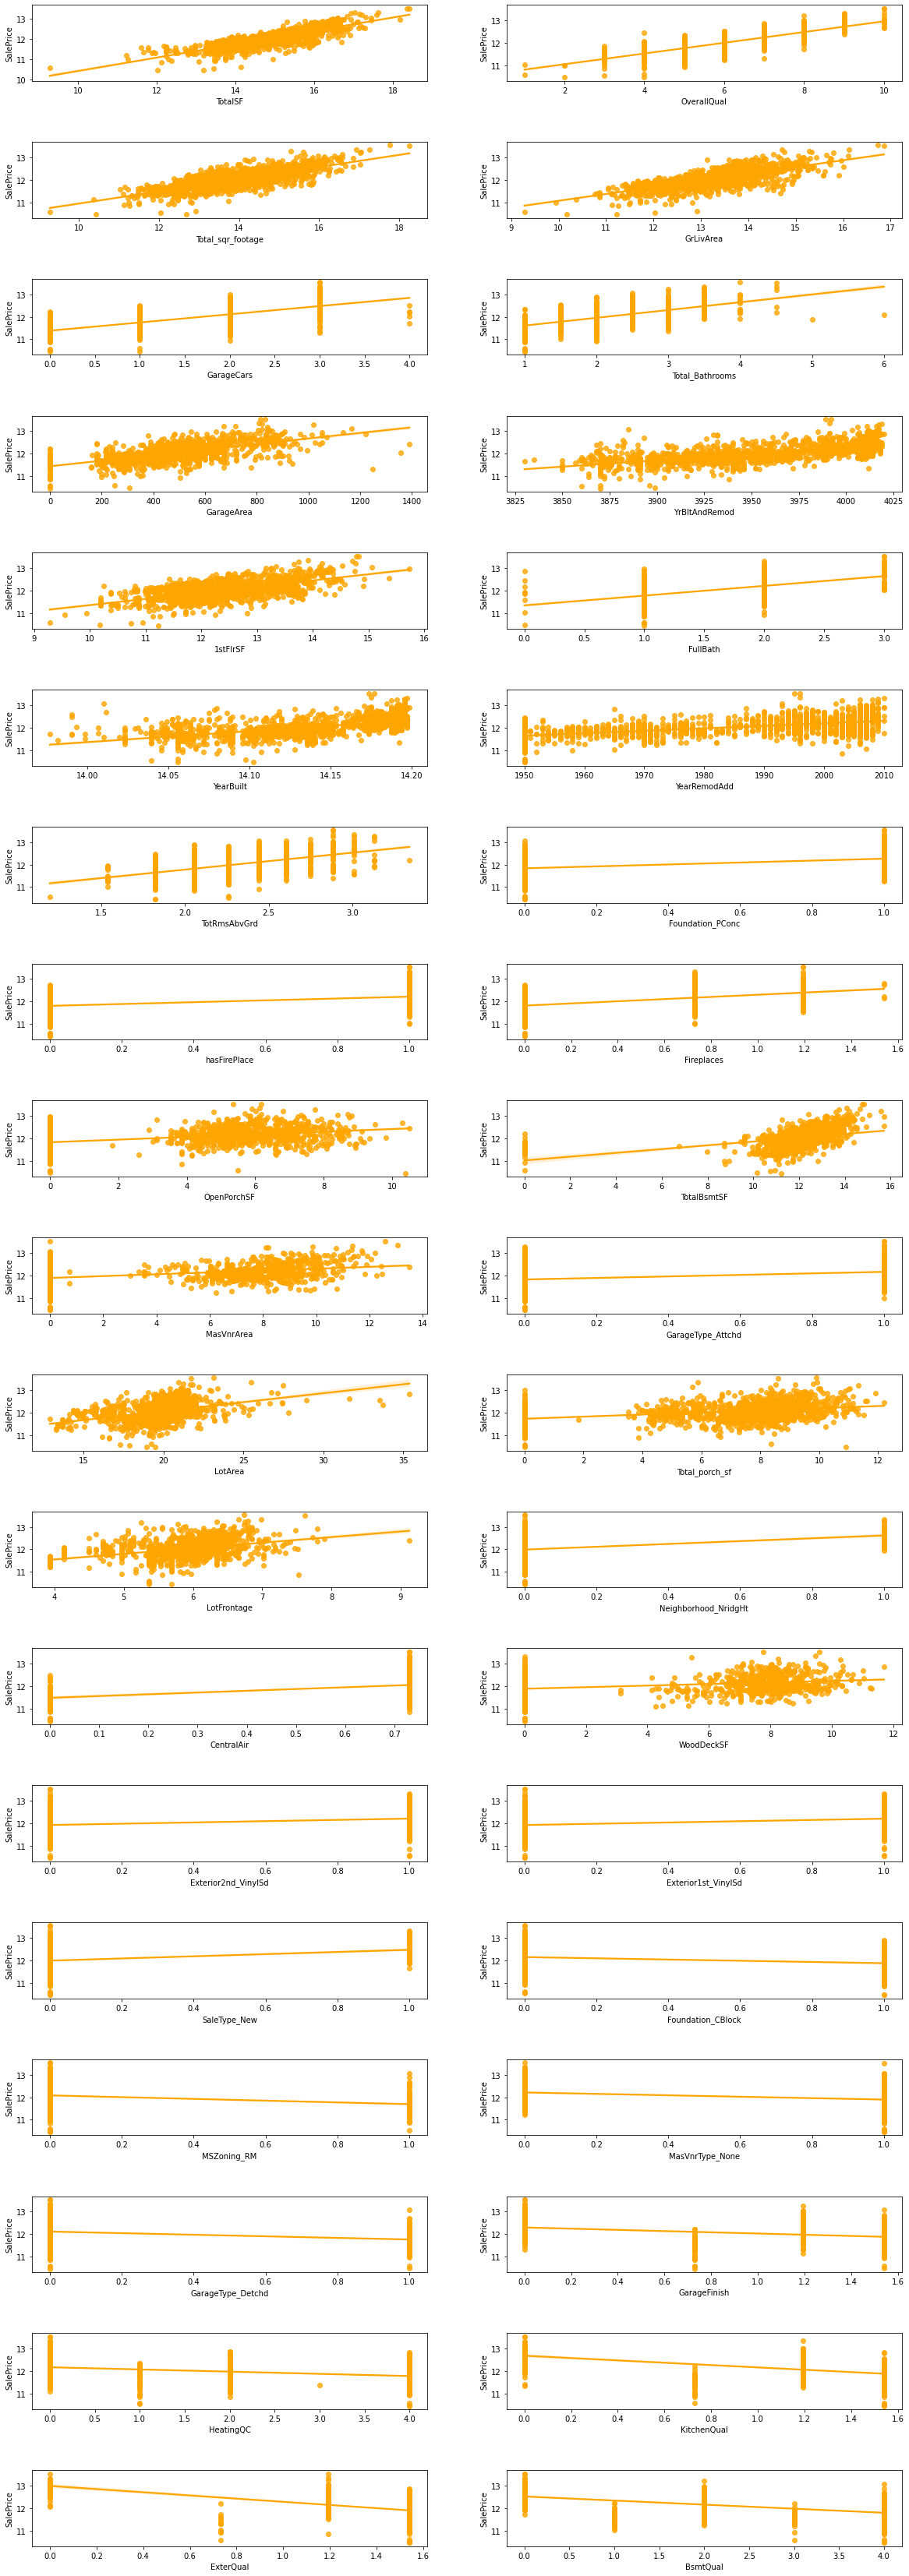

In [62]:
#각 피처들과 타겟 데이터의 관계 시각화
row = 19
col = 2

fig, ax = plt.subplots(row, col, figsize = (20, 60))
fig.subplots_adjust(hspace=0.8) #세로 간격 설정

for r in range(row):
    for c in range(col):
        i = r*col + c
        if i < len(best_columns):
            sns.regplot(final_train_data[final_num[i]], target_data, fit_reg=True, marker='o', color='orange',ax = ax[r][c])

# 모델링

In [63]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression

In [64]:
from sklearn.preprocessing import RobustScaler

In [65]:
#데이터 스케일링
rbst_scaler = RobustScaler() #이상치의 영향을 줄이기 위해 평균값 대신 중앙값을 사용하는 RobustScaler사용
x_rbst = rbst_scaler.fit_transform(new_train_data)
test_rbst = rbst_scaler.fit_transform(new_test_data)

In [66]:
#선형회귀모델
import statsmodels.api as sm

model  = sm.OLS(target_data.values, new_train_data) #결정론적 회귀 방법인 OLS 사용
re = model.fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     104.6
Date:                Tue, 26 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:30:57   Log-Likelihood:                 1389.0
No. Observations:                1458   AIC:                            -2362.
Df Residuals:                    1250   BIC:                            -1263.
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass               -0.0013      0.003     -0.376      0.707      -0.008       0.005
LotFrontage               0.0085      0.008      1.036      0.301      -0.008       0.025
LotArea                   0.0225      0.003      8.331      0.000       0.017       0.028
Street                    0.1257      0.069      1.815      0.070      -0.010       0.262
Alley                     0.0153      0.021      0.726      0.468      -0.026       0.057
LotShape                  0.0055      0.005      1.206      0.228      -0.003       0.014
LandSlope                 0.0228      0.021      1.061      0.289      -0.019       0.065
OverallQual               0.0414      0.004      9.369      0.000       0.033       0.050
OverallCond               0.1670      0.015     10.942      0.000       0.137       0.197
YearBuilt               -14.4624     18.658     -0.775      0.438     -51.066      22.141
YearRemodAdd             -0.0242      0.030     -0.807      0.420      -0.083       0.035
MasVnrArea                0.0010      0.003      0.389      0.697      -0.004       0.006
ExterQual                -0.0237      0.014     -1.659      0.097      -0.052       0.004
ExterCond                 0.0079      0.013      0.611      0.541      -0.018       0.033
BsmtQual                 -0.0083      0.004     -2.220      0.027      -0.016      -0.001
BsmtCond                  0.0106      0.008      1.321      0.187      -0.005       0.026
BsmtExposure             -0.0055      0.006     -0.875      0.382      -0.018       0.007
BsmtFinType1             -0.0014      0.002     -0.614      0.539      -0.006       0.003
BsmtFinSF1                0.0001      0.002      0.064      0.949      -0.004       0.004
BsmtFinType2             -0.0119      0.013     -0.942      0.347      -0.037       0.013
BsmtFinSF2               -0.0041      0.002     -2.261      0.024      -0.008      -0.001
BsmtUnfSF                -0.0008      0.002     -0.410      0.682      -0.004       0.003
TotalBsmtSF               0.0105      0.020      0.535      0.593      -0.028       0.049
HeatingQC                -0.0075      0.002     -3.455      0.001      -0.012      -0.003
CentralAir                0.0689      0.023      2.981      0.003       0.024       0.114
1stFlrSF                  0.0208      0.020      1.027      0.304      -0.019       0.061
2ndFlrSF                  0.0283      0.010      2.800      0.005       0.008       0.048
LowQualFinSF              0.0027      0.004      0.631      0.528      -0.006       0.011
GrLivArea                 0.0125      0.039      0.323      0.747      -0.063       0.088
BsmtFullBath             -0.0851      0.106     -0.806      0.420      -0.292       0.122
BsmtHalfBath             -0.0487      0.056     -0.865      0.387      -0.159       0.062
FullBath               

모델의 r-square(설명력)값이 1로 굉장히 높지만 변수들중 P-value가 높은 값들이 존재하며 **다중공선성**의 문제가 있을 수 있다

In [67]:
#다중공산성 문제 여부의 확인을 위해 vif확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = new_train_data.columns
vif['vif'] = [variance_inflation_factor(new_train_data.values, i)  for i in range(new_train_data.shape[1])]

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [68]:
vif.sort_values(by='vif', ascending=False)[165:190]

,Features,vif
40,GarageYrBlt,44201.767159
63,haspool,3375.516181
52,PoolArea,3114.411164
61,Total_Bathrooms,495.719012
26,2ndFlrSF,471.396022
58,TotalSF,318.881940
64,has2ndFloor,311.452414
22,TotalBsmtSF,258.905595
31,FullBath,249.237321
29,BsmtFullBath,217.805638


vif가 10 이상이면 다중공선성이 존재한다고 하는데 많은 변수들이 다중공선성 문제 존재

해결 방안으로는

1.다중공선성에 robust한 트리모델을 사용하는 방법

2.변수제거 및 FE, 변환등을 통한 대체

3.관측값을 늘려 표본의 크기를 증가

주어진 데이터로 인하여 표본의 크기를 증가할 수 없기 때문에 robust한 트리모델을 사용하는 방법을 택하였습니다.

*Robust : 중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화

In [69]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

kfold = KFold(n_splits=4)
reg = []

reg.append(Lasso(random_state = 21))
reg.append(ElasticNet(random_state = 21))
reg.append(RandomForestRegressor(random_state = 21))
reg.append(GradientBoostingRegressor(random_state = 21))
reg.append(XGBRegressor(verbosity = 0,random_state = 21))
reg.append(LGBMRegressor(verbosity = 0, random_state = 21))
reg

[Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=21,
       selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=21, selection='cyclic', tol=0.0001, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=21, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedm

In [70]:
reg_results = []

for regresult in reg:
    reg_results.append(np.mean(np.sqrt(-cross_val_score(regresult, x_rbst, y = target_data, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1))))
reg_results

[0.3786926175400557,
 0.3782268874012694,
 0.13675259973999473,
 0.12175273882486023,
 0.12446307851981778,
 0.12825422491545166]

In [71]:
reg_means = []
reg_std = []
for reg_result in reg_results:
    reg_means.append(reg_result.mean())
    reg_std.append(reg_result.std())
    
reg_re = pd.DataFrame({'CrossValMeans':reg_means, 'CrossValerrors':reg_std})
reg_re

,CrossValMeans,CrossValerrors
0,0.378693,0.0
1,0.378227,0.0
2,0.136753,0.0
3,0.121753,0.0
4,0.124463,0.0
5,0.128254,0.0


성능이 좋은 3개의 모델(GradientBoosting, XGBoost, LGBM)에 대하여 파라미터 튜닝을 시작 

In [72]:
#GradientBoosting 파라미터 튜닝
gbr = GradientBoostingRegressor()
gb_param_grid = {'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
gsGBR = GridSearchCV(gbr, param_grid = gb_param_grid, cv = kfold, scoring = 'neg_mean_squared_error', verbose = 1)
gsGBR.fit(x_rbst, target_data)
GBR_best = gsGBR.best_estimator_

gsGBR.best_score_

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.3min finished


-0.017664211066111303

In [78]:
#XGBoost 파라미터 튜닝
XGB = XGBRegressor(objective='reg:squarederror')
xgb_param_grid = {'learning_rate': [1,0.1,0.01,0.001],
              'n_estimators': [50, 100, 200, 500, 1000],
              'max_depth' : [1,3,5,10,50]}
gsXGB = GridSearchCV(XGB, param_grid = xgb_param_grid, cv = kfold, scoring='neg_mean_squared_error', verbose = 1)
gsXGB.fit(x_rbst, target_data)
XGB_best = gsXGB.best_estimator_

gsXGB.best_score_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 14.6min finished


-0.014016723093284918

In [79]:
#LGBM 파라미터 튜닝
LGB = LGBMRegressor()
lgb_param_grid = {
    'num_leaves' : [1,5,10],
    'learning_rate': [1,0.1,0.01,0.001],
    'n_estimators': [50, 100, 200, 500, 1000,5000], 
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'min_split_gain': [0.3, 0.4],
}
gsLGB = GridSearchCV(LGB, param_grid = lgb_param_grid, cv=kfold, scoring = 'neg_mean_squared_error', verbose=1)
gsLGB.fit(x_rbst, target_data)
LGB_best = gsLGB.best_estimator_

gsLGB.best_score_

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 20.6min finished


-0.018533039905470252

# 예측

**1. 앙상블**

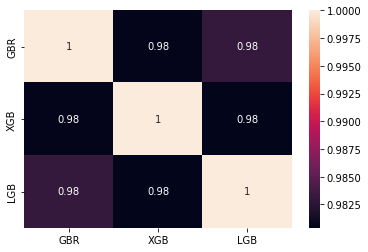

In [82]:
test_Survived_GBR = pd.Series(GBR_best.predict(test_rbst), name='GBR')
test_Survived_XGB = pd.Series(XGB_best.predict(test_rbst), name='XGB')
test_Survived_LGB = pd.Series(LGB_best.predict(test_rbst), name='LGB')

ensemble_results = pd.concat([test_Survived_GBR, test_Survived_XGB, test_Survived_LGB], axis=1)
g = sns.heatmap(ensemble_results.corr(), annot=True)

In [83]:
ensemble = np.expm1(0.1*test_Survived_GBR + 0.8*test_Survived_XGB + 0.1*test_Survived_LGB)
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': ensemble})
submission.head()

,Id,SalePrice
0,1461,129540.949534
1,1462,171076.578778
2,1463,182951.640986
3,1464,194008.384848
4,1465,204399.938744


3가지 모델을 heatmap을 통해서 상관관계를 비교해보고 상관성이 높은 XGB와 GBC 모델을 이용하여 앙상블 모델을 만들어서 결과를 제출

**2. Voting**

In [84]:
from sklearn.ensemble import VotingRegressor

votingR = VotingRegressor(estimators=[('XGB', XGB_best), ('LGB' ,LGB_best), ('GBR', GBR_best)])
votingR = votingR.fit(x_rbst, target_data)

In [85]:
test_SalePrice = pd.Series(votingR.predict(test_rbst), name='SalePrice')
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': np.expm1(test_SalePrice)})
submission.head()

,Id,SalePrice
0,1461,129817.568291
1,1462,171711.432526
2,1463,179755.166705
3,1464,192738.370616
4,1465,195241.695828


**3. Stacking**

In [86]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.utils.testing import ignore_warnings

In [87]:
params = {'meta_regressor__C': [0.1, 1.0, 10.0, 100.0], 'use_features_in_secondary' : [True, False]}
rgs1 = XGB_best
rgs2 = LGB_best
rgs3 = GBR_best

lr = LogisticRegression()
st_re = StackingRegressor(regressors = [rgs1, rgs2, rgs3], meta_regressor = RandomForestRegressor())
st_mod = st_re.fit(x_rbst, target_data)
st_pred = st_mod.predict(test_rbst)

In [88]:
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': np.expm1(st_pred)})
submission.head()

,Id,SalePrice
0,1461,132626.928569
1,1462,170725.907162
2,1463,182732.711632
3,1464,203988.548073
4,1465,186084.039116


**4. Blending**

In [89]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=21)

In [90]:
def rmsle(y_,y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=new_train_data):
    rmse = np.sqrt(-cross_val_score(model, x_rbst, target_data, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse

In [91]:
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_enect = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
enect_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [92]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor

In [93]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds))

In [94]:
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas = alphas_lasso, cv=kfolds))

In [95]:
enet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas = alphas_enect, cv=kfolds))

In [96]:
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

In [97]:
stack_gen = StackingCVRegressor(regressors = (ridge, lasso, enet, svr, GBR_best, XGB_best, LGB_best), meta_regressor = XGB_best, use_features_in_secondary=True)

In [98]:
score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(enet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(GBR_best)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(XGB_best)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(LGB_best)
print("LightGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

Kernel Ridge score: 0.1101 (0.0113)

Lasso score: 0.1093 (0.0098)

ElasticNet score: 0.1091 (0.0099)

SVR score: 0.1106 (0.0160)

GradientBoosting score: 0.1298 (0.0105)

XGBoost score: 0.1190 (0.0102)

LightGBM score: 0.1364 (0.0154)



In [99]:
stack_gen_model = stack_gen.fit(np.array(x_rbst), np.array(target_data))
elastic_model_full_data = enet.fit(x_rbst, target_data)
lasso_model_full_data = lasso.fit(x_rbst, target_data)
ridge_model_full_data = ridge.fit(x_rbst, target_data)
svr_model_full_data = svr.fit(x_rbst, target_data)
gbr_model_full_data = GBR_best.fit(x_rbst, target_data)
xgb_model_full_data = XGB_best.fit(x_rbst, target_data)
lgb_model_full_data = LGB_best.fit(x_rbst, target_data)

In [100]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

In [101]:
pred = np.floor(np.expm1(blend_models_predict(test_rbst)))
submission = pd.DataFrame({
    "Id" :test_data['Id'],
    "SalePrice": pred
})
submission.head()

,Id,SalePrice
0,1461,127524.0
1,1462,172285.0
2,1463,184738.0
3,1464,200261.0
4,1465,197727.0


In [102]:
submission.to_csv('final_submission.csv', index=False)